# Research Question 1 - Order-Invariant Assumption

Since the deep-learning model receives knowledge paths without any rank-related information, intuitively, the attention mechanism can only judge the quality of a knowledge path based on its content. Therefore, the ordering of the knowledge paths should not impact the dependent variable. In other words, the attention mechanism will not favor knowledge paths in certain positions; this could occur when the position's average quality of the knowledge path is systematically higher than others' average quality.

Based on intuition, the project has held the order-invariant assumption during the development of other systems. This analysis aims to verify the validity of this assumption.

In [1]:
import pickle

with open("data/human.pkl", "rb") as human, open("data/comet.pkl", "rb") as comet:
    experiments = pickle.load(human) + pickle.load(comet)

print(f"Total number of experiments: {len(experiments)}")

Total number of experiments: 14


`float32`, used by the system, has a precision of up to 7 significant figures. Under the order-invariant assumption, all observations in a sample should converge to a single value within the theoretical limitation of `float32`.

In [2]:
def float32_precision_test(observations):
    observations = observations.apply(lambda x: float(format(x, ".7g")))
    
    return observations.nunique() == 1

def float32_aggrement_test(observations):
    for digit in range(7, -1, -1):
        if observations.apply(lambda x: float(format(x, f".{digit}g"))).nunique() == 1:
            return digit

## Analysis on Prediction Vector

In [3]:
import pandas as pd

HUMAN_NEEDS = ("status", "approval", "tranquility", "competition", "health", "family", "romance", "food",
               "independence","power", "order", "curiosity", "serenity", "honor", "belonging", "contact",
               "savings", "idealism", "rest")

predictions = pd.DataFrame(
    ((e.story, e.sentence, e.character, i.human_size, i.machine_size, need, value)
     for e in experiments for i in e.instances for s in i.samples
     for need, value in zip(HUMAN_NEEDS, s.result)),
    columns=("story", "line", "character", "human_size", "machine_size", "need", "value")
)

predictions

,story,line,character,human_size,machine_size,need,value
0,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,0,status,0.346841
1,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,0,approval,0.281792
2,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,0,tranquility,0.508339
3,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,0,competition,0.395357
4,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,0,health,0.541861
...,...,...,...,...,...,...,...
27967995,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),15,61,belonging,0.000444
27967996,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),15,61,contact,0.314838
27967997,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),15,61,savings,0.334682
27967998,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),15,61,idealism,0.491077


Since this analysis only focuses on the system's behavior, the effects of human-like knowledge paths are removed (`human_size == 0`); since this analysis only focuses on the order of knowledge paths, the effects of knowledge path selection are removed (`machine_size == machine_size.max()`).

In [4]:
predictions = predictions.groupby(["story", "line", "character"])\
    .apply(lambda x: x[(x.human_size == 0) & (x.machine_size == x.machine_size.max())])\
    .reset_index(drop=True)[["story", "line", "character", "need", "value"]]

predictions

,story,line,character,need,value
0,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,status,0.481567
1,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,approval,0.310710
2,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,tranquility,0.039941
3,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,competition,0.401482
4,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,health,0.035084
...,...,...,...,...,...
26595,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),belonging,0.000444
26596,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),contact,0.314826
26597,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),savings,0.334675
26598,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),idealism,0.491077


### Float 32 Test

The test described above is performed for each inference instance on each human need category. The result indicates whether the observations follow the order-invariant assumption or not.

In [5]:
predictions.groupby(["story", "line", "character", "need"]).value\
    .apply(float32_precision_test)\
    .to_frame("expected")\
    .pivot_table("expected", ["story", "line", "character"], "need")

need                                                   approval  belonging  \
story                                line character                          
0428b530-0cec-4955-b023-0bac60ddf8cc 5    Gina             True      False   
0463f79e-2d83-44b7-ad1f-5bcb3f5fd947 3    Finn            False      False   
                                     4    Finn            False      False   
047a5159-6595-4ec2-b7e6-2807b5f0fc78 1    Gary             True      False   
                                     2    Gary             True      False   
05c4681d-f365-438b-8509-58461afb2935 5    A small boy     False      False   
061a896e-12bb-4f3a-a8ec-7e4188228ac9 5    I (myself)       True      False   

need                                                   competition  contact  \
story                                line character                           
0428b530-0cec-4955-b023-0bac60ddf8cc 5    Gina                True     True   
0463f79e-2d83-44b7-ad1f-5bcb3f5fd947 3    Finn                True    False   
                                     4    Finn               False    False   
047a5159-6595-4ec2-b7e6-2807b5f0fc78 1    Gary               False    False   
                                     2    Gary               False    False   
05c4681d-f365-438b-8509-58461afb2935 5    A small boy        False    False   
061a896e-12bb-4f3a-a8ec-7e4188228ac9 5    I (myself)         False     True   

need                                                   curiosity  family  \
story                                line character                        
0428b530-0cec-4955-b023-0bac60ddf8cc 5    Gina             False   False   
0463f79e-2d83-44b7-ad1f-5bcb3f5fd947 3    Finn             False    True   
                                     4    Finn              True    True   
047a5159-6595-4ec2-b7e6-2807b5f0fc78 1    Gary             False   False   
                                     2    Gary             False    True   
05c4681d-f365-438b-8509-58461afb2935 5    A small boy      False   False   
061a896e-12bb-4f3a-a8ec-7e4188228ac9 5    I (myself)       False    True   

need                                                    food  health  honor  \
story                                line character                           
0428b530-0cec-4955-b023-0bac60ddf8cc 5    Gina         False   False   True   
0463f79e-2d83-44b7-ad1f-5bcb3f5fd947 3    Finn          True   False   True   
                                     4    Finn          True    True  False   
047a5159-6595-4ec2-b7e6-2807b5f0fc78 1    Gary         False   False   True   
                                     2    Gary         False   False   True   
05c4681d-f365-438b-8509-58461afb2935 5    A small boy  False    True   True   
061a896e-12bb-4f3a-a8ec-7e4188228ac9 5    I (myself)   False   False   True   

need                                                   idealism  independence  \
story                                line character                             
0428b530-0cec-4955-b023-0bac60ddf8cc 5    Gina            False          True   
0463f79e-2d83-44b7-ad1f-5bcb3f5fd947 3    Finn             True          True   
                                     4    Finn             True         False   
047a5159-6595-4ec2-b7e6-2807b5f0fc78 1    Gary            False          True   
                                     2    Gary            False          True   
05c4681d-f365-438b-8509-58461afb2935 5    A small boy     False          True   
061a896e-12bb-4f3a-a8ec-7e4188228ac9 5    I (myself)       True          True   

need                                                   order  power   rest  \
story                                line character                          
0428b530-0cec-4955-b023-0bac60ddf8cc 5    Gina         False  False  False   
0463f79e-2d83-44b7-ad1f-5bcb3f5fd947 3    Finn          True   True  False   
                                     4    Finn         False  False  False   
047a5159-6595-4ec2-b7e6-2807b5f0fc78 1    Gary         False  False 

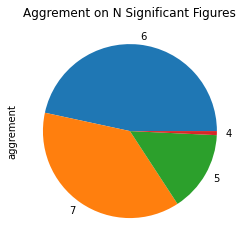

In [6]:
predictions.groupby(["story", "line", "character", "need"]).value\
    .apply(float32_aggrement_test)\
    .rename("aggrement")\
    .value_counts()\
    .plot(kind="pie", title="Aggrement on N Significant Figures")

Base on the result, not all observations converge within the limit of 7 significant figures - invalidating the order-invariant assumption for prediction vector. However, all observations converge within the limit of 4 significant figures. Thus, although there is a detectable influence, it does not significantly impact the model's prediction.

## Analysis on Attention

In [7]:
import itertools

attentions = pd.DataFrame(
    ((e.story, e.sentence, e.character, i.human_size, i.machine_size, p.content, p.index, p.weight)
     for e in experiments for i in e.instances for s in i.samples
     for p in itertools.chain(s.human_paths, s.machine_paths)
     if i.human_size == 0),
    columns=("story", "line", "character", "human_size", "machine_size", "path", "index", "value")
)

attentions

,story,line,character,human_size,machine_size,path,index,value
0,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,1,nightmare Synonym incubus related to sleep has...,0,1.000000
1,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,1,beat has context fencing Causes competition,0,1.000000
2,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,1,put related to place manner of order,0,1.000000
3,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,1,nightmare Synonym night_terror is a disease An...,0,1.000000
4,0463f79e-2d83-44b7-ad1f-5bcb3f5fd947,3,Finn,0,1,put Synonym invest related to power,0,1.000000
...,...,...,...,...,...,...,...,...
2980995,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),0,61,go_home MotivatedByGoal tired HasSubevent rest,56,0.020976
2980996,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),0,61,power related to motor related to go,57,0.000001
2980997,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),0,61,home related to love,58,0.000365
2980998,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),0,61,status related to condition related to report ...,59,0.000010


In [8]:
attentions = attentions.groupby(["story", "line", "character"])\
    .apply(lambda x: x[(x.human_size == 0) & (x.machine_size == x.machine_size.max())])\
    .reset_index(drop=True)[["story", "line", "character", "path", "index", "value"]]

attentions

,story,line,character,path,index,value
0,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,status related to condition related to mint re...,0,1.349792e-16
1,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,pretend HasSubevent fun has property free rela...,1,2.290936e-10
2,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,curiosity Antonym ignorance derived from ignor...,2,4.857674e-16
3,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,belonging related to family related to childre...,3,4.167367e-18
4,0428b530-0cec-4955-b023-0bac60ddf8cc,5,Gina,love causes desire paint related to ugly,4,5.907698e-15
...,...,...,...,...,...,...
90595,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),go_home MotivatedByGoal tired HasSubevent rest,56,2.097624e-02
90596,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),power related to motor related to go,57,1.001262e-06
90597,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),home related to love,58,3.652186e-04
90598,061a896e-12bb-4f3a-a8ec-7e4188228ac9,5,I (myself),status related to condition related to report ...,59,9.749450e-06


### Float 32 Test

The test described above is performed for each inference instance on each knowledge path. The result indicates whether the observations follow the order-invariant assumption or not.

In [9]:
attentions.groupby(["story", "line", "character", "path"]).value\
    .apply(float32_precision_test)\
    .to_frame("expected")

expected
story                                line character  path                                                        
0428b530-0cec-4955-b023-0bac60ddf8cc 5    Gina       approval related to ok Antonym ill Synonym ugly        False
                                                     approval similar to acclamation has context art...      True
                                                     belonging Synonym possession at location house ...      True
                                                     belonging related to family related to children...      True
                                                     calm Antonym anger Etymologicallyrelated to ugly        True
...                                                                                                           ...
061a896e-12bb-4f3a-a8ec-7e4188228ac9 5    I (myself) safety Synonym guard related to worker CapableO...     False
                                                     safety related to security is a worker CapableO...      True
                                                     social related to party Antonym home                   False
                                                     status related to condition related to report r...     False
                                                     status related to position related to place rel...     False

[453 rows x 1 columns]

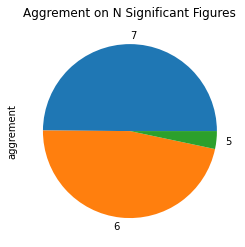

In [10]:
attentions.groupby(["story", "line", "character", "path"]).value\
    .apply(float32_aggrement_test)\
    .rename("aggrement")\
    .value_counts()\
    .plot(kind="pie", title="Aggrement on N Significant Figures")

Base on the result, not all observations converge within the limit of 7 significant figures - invalidating the order-invariant assumption for prediction vector. However, all observations converge within the limit of 5 significant figures. Thus, although there is a detectable influence, it does not significantly impact the model's prediction.

## Preference Based on Position

As described above, the attention mechanism may favor knowledge path certain positions. This analysis investigates the validity of the statement. [The distance correlation test](https://en.wikipedia.org/wiki/Distance_correlation) is used since no assumption on the type of correlation (i.e., linear, quadratic, exponential, etc.) should be made.

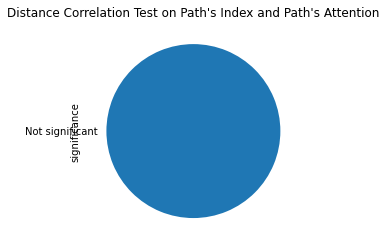

In [11]:
from dcor.independence import distance_covariance_test

def classification(p):
    if p < 0.001:
        return "Significant at 0.001"
    elif p < 0.01:
        return "Significant at 0.01"
    elif p < 0.05:
        return "Significant at 0.05"
    
    return "Not significant"

attentions.groupby(["story", "line", "character", "path"])\
    .apply(lambda x: distance_covariance_test(x.index, x.value)[0])\
    .apply(classification)\
    .rename("significance")\
    .value_counts()\
    .plot(kind="pie", title="Distance Correlation Test on Path's Index and Path's Attention")

The result indicates no correlation exists between the knowledge path's position and it's attention weight.

## Conclusion

Based on 23 experiments, each with 100 samples, negligible changes exist in the prediction vector and knowledge path attention vector.

Although the current training process does not result in a position-based preference in the attention mechanism, alteration to the process could potentially induce such behavior. A position-based preference will enable the indirect human intervention on the system's judgment of knowledge path quality.